In [1]:

using Plots
using Printf
using DataStructures: OrderedDict
using NCDatasets


   Resolving package versions...
  No Changes to `/global/u1/s/siennaw/.julia/environments/v1.10/Project.toml`
  No Changes to `/global/u1/s/siennaw/.julia/environments/v1.10/Manifest.toml`


In [ ]:
using CSV, DataFrames
# import Pkg; Pkg.add("DataFrames")
 


# Wind time series 
wind_fn = "/global/homes/s/siennaw/scratch/siennaw/turbulence-model/data/forcing_data/wind_on_august_10-16.csv"
df = CSV.read(wind_fn, DataFrame)
wind = df[!,"WindSpeed"]

temp_fn = "/global/homes/s/siennaw/scratch/siennaw/turbulence-model/data/forcing_data/temp_on_august_10-16.csv"
temp = CSV.read(temp_fn, DataFrame)

print(temp)



51841

In [3]:

cm2m = 0.01
hr2s = 1/3600


1.388888888888889e-5

In [51]:

include("calculate_physical_variables.jl") 
include("advance_variables.jl")
include("phytoplankton.jl")
include("forcings.jl") 
include("output.jl")

#********************** SPATIAL DOMAIN  ***************************
N = 60    # number of grid points
H = 7    # depth (meters)
dz = H/N  # grid spacing - may need to adjust to reduce oscillations
dt = 10   # (seconds) size of time step 
M  = 10000 

# Increments for saving profiles. set to 1 to save all; 10 saves every 10th, etc. 
isave = 1000
var2save = ["U", "C", "Kz", "algae1","algae2"]

create_output_dict(M, isave, var2save, N)

# Create depth vector 
z = collect(H:-dz:dz) .- dz/2 # depth vector
println("Length of z is ", length(z))

#********************** FIXED CONSTANTS  ***************************
rhoA = 1.23                     # Density of air, kg/m^3
rhoW = 1000                     # Density of water, kg/m^3
specific_heat_water = 4181      # J/kg-degC
specific_heat_air = 1007        # J/kg-degC x RH
c_d = 0.05                      # Drag coefficient [-]

#********************** INITIAL CONDITION ***************************
# Initialize thermocline based on tanh curve 
base_temp = 22
dtemp = 1.5 
stretch = 0.25 

#********************** DEFINE HYDRODYNAMIC FORCINGS ***************************
# (1) PRESSURE 
Px0 = 2e-5          # Pressure gradient forcing
T_Px = 12           # Period [hours] on pressure gradient forcing. Set to 0 for steady

# (2) Wind
Wind = 1                       # u_star =m/s >> 0.05 is  drag coefficient, 10 is my wind speed 
WIND = (c_d * Wind)^2 * rhoA   # this is rho * u*^2

# (3) Temperature
top_temp = 33
bottom_temp = 30
bottom_speed = 0 
top_speed=3.5  

# (4) Light 
DIURNAL_LIGHT = false  
background_turbidity =  0.6
I_in = 350 


#********************** DEFINE PHYTOPLANKTON FORCINGS ***************************
init_algae = 0.5 

algae1 = Dict("k" => 0.7,              # specific light attenuation coefficient [cm^2 / 10^6 cells]
            "pmax" => 0.05 * hr2s,          # maximum specific growth rate [1/hour]
            "ws" => -1.38e-5,           # vertical velocity [m/s]
            "Hi" => 40,                 # half-saturation of light-limited growth [mu mol photons * m^2/s]
            "Li" => 0.006 * hr2s,             # specific loss rate [1/hour]
            "name" => "Diatom",           # name of the species
            "self_shading" => true)    # self-shading effect (true/false))       

algae2 = Dict("k" => 0.034,              # specific light attenuation coefficient [cm^2 / 10^6 cells]
              "pmax" => 0.008 * hr2s,           # maximum specific growth rate [1/hour]
              "ws" => 1.38e-4,           # vertical velocity [m/s]
              "Hi" => 40,                # half-saturation of light-limited growth [mu mol photons * m^2/s]
              "Li" => 0.004 * hr2s,             # specific loss rate [1/hour]
              "name" => "HAB",           # name of the species
              "self_shading" => true)    # self-shading effect (true/false)
# '''
# Diatoms ws = -1.38e-5 m/s
# Cyanobacteria = 1.38e-4 m/s
# '''

#***************************************************************************
#   Initialize variables
#***************************************************************************

# Create dictionary to hold important discretization parameters
discretization = Dict("beta" => (dt/dz^2), "dz" => dz, "dt" => dt, "N" => N, "z"=> z, "H" => H)

# Initalize velocity
U = zeros(N) .+ 1e-1
C = zeros(N) .+ LinRange(bottom_temp, top_temp, N)  
rho = calculate_rho(C, base_temp) 
N_BV2 = calculate_brunt_vaisala(rho, discretization)

algae1["c"] = zeros(N) .+ init_algae 
algae2["c"] = zeros(N) .+ init_algae 

Q2, Q2L, Q, L, Gh, nu_t, Kq, Kz = initialize_turbulent_functions(discretization, N_BV2)

# Initial dictionary to store variables
variables = Dict("U" => U, "C" => C, "N_BV2" => N_BV2, 
                "Nu" => nu_t, "Q2" => Q2, "Q2L" => Q2L, 
                "Kq" => Kq, "Kz" => Kz, "L" => L)

Times = 1:dt:M*dt

#***************************************************************************

for i in 1:M
    time = Times[i];

    # [1] Advance velocity field
    pressure = get_pressure_at_timestamp(time, T_Px)
    ustar = calculate_ustar(U)
    wind_stress = wind_speed_2_wind_stress(0.1) 
    U = advance_velocity(variables, pressure, discretization, wind_stress)

    #  [2] Advance TKE / Q2 
    Q2 = advance_Q2(variables, ustar, discretization) 
    Q = @. sqrt(Q2)

    #  [3] Advance Q2*L      
    Q2L = advance_Q2L(variables, ustar, discretization)
   
    #  [4] Advance temperature 
    C = advance_scalar(variables, discretization)

    # [5] Calculate density from temperature field
    rho = calculate_rho(C, base_temp) 

    # [6] Calculate Brunt-Vaisala frequency 
    N_BV2 = calculate_brunt_vaisala(rho, discretization)

    # [7] Semi-implicit: Calculate turbulent lengthscale
    L = calculate_lengthscale(Q2, Q2L, N_BV2, discretization)
    nu_t, Kq, Kz = calculate_turbulent_functions(Gh, Q, L, discretization) 

    # println("algae1 c = ", algae1["c"])
    # println("algae2 c = ", algae2["c"])
    
    # [8] Advance phytoplankton
    I0 = diurnal_light(time, I_in, 0, DIURNAL_LIGHT)
    light = self_shading(algae1, algae2, I0, background_turbidity, discretization)

    # println("i = $i")
    # println(light)
    # display(plot( light, -z))
    # break 

    # Algae 1
    gamma = calculate_net_growth(algae1, light, discretization)
    
    # println("Algae 1 = ", algae1["c"])
    # println("gamma 1 = ", gamma)
    algae1["c"] = advance_algae(variables, algae1, gamma, discretization)
    # println("Algae 1 = ", algae1["c"])

    # Algae 2
    gamma = calculate_net_growth(algae2, light, discretization) 
    algae2["c"] = advance_algae(variables, algae2, gamma, discretization)
    
    # [9] Pack variables for next timestep 
    variables["U"] = U
    variables["C"] = C
    
    variables["N_BV2"] = N_BV2
    variables["Nu"] = nu_t
    variables["Q2"] = Q2
    variables["Q2L"] = Q2L
    variables["Kq"] = Kq
    variables["Kz"] = Kz
    variables["L"] = L

    if i % isave == 0
        print("I = $i \n")
        index = div(i, isave)
        print("C= $C")
        save2output(time, index, "algae1", algae1["c"])
        save2output(time, index, "algae2", algae2["c"])
        save2output(time, index, "U", variables["U"])
        save2output(time, index, "Kz", variables["Kz"])
        
    end



end

U
C
Kz
algae1
algae2
Length of z is 60
I = 1000 
C= [30.14647591134081, 30.14709708385628, 30.148778526678655, 30.153042652358383, 30.167977217072274, 30.207419820639533, 30.254701083750327, 30.31146356936464, 30.37933813892507, 30.461010404276866, 30.52521049296036, 30.57227991214064, 30.616609869814912, 30.663571067110638, 30.71291544006994, 30.762924655119257, 30.81366270854549, 30.8644368378966, 30.91526529649995, 30.966105299099866, 31.016950167126183, 31.067796852867154, 31.118644111923132, 31.169491525901847, 31.220338976206815, 31.271186433938922, 31.322033892961255, 31.37288135213692, 31.423728811293582, 31.474576270423395, 31.525423729542865, 31.576271188671956, 31.62711864783159, 31.677966107043314, 31.728813566330842, 31.779661025720703, 31.830508485241452, 31.88135594492455, 31.932203404831434, 31.983050865126568, 32.0338983258292, 32.084745785243314, 32.135593240352684, 32.18644070866864, 32.23728826441818, 32.28813584394024, 32.338982494917055, 32.3898271386376, 32.44067

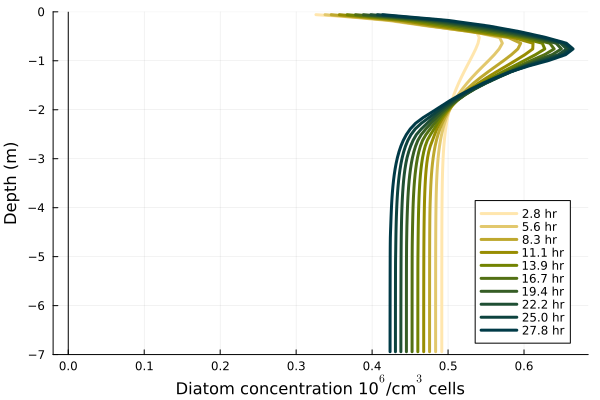

In [50]:


using Colors
using ColorSchemes
using Plots
using Printf


using LaTeXStrings

units_dict = Dict("U" => "m/s", 
                    "C" => "deg C", 
                    "Kz" => "m\$^2\$ s\$^{-1}\$", 
                    "algae1" => L"10$^6$/cm$^3$ cells",
                    "algae2" => L"10$^6$/cm$^3$ cells")

var2name = Dict("U" => "Velocity", 
                    "C" => "Temperature", 
                    "Kz" => "Turbulent diffusivity", 
                    "algae1" => "Diatom concentration",
                    "algae2" => "HAB concentration")
var = "algae1"


times2 = unique(times)
p1 = plot()
vline!([0], color=:black, label="")

h = get(ColorSchemes.bamako, range(1.0, 0.0, length=10) )

for i in 1:10
    minutes = times2[i] / 3600
    plot!(output[var][:,i], -z, linewidth=3, label= @sprintf("%2.1f hr", minutes), color=h[i])
end


ylims!(-H, 0)
xlabel!(@sprintf("%s %s", var2name[var], units_dict[var]))
ylabel!("Depth (m)")
display(p1)


In [31]:



ds = NCDataset("test.nc","c")

ds.attrib["title"] = "Saving results from my Julia model run..."


defDim(ds, "z", length(z)) 
defDim(ds, "time", length(times2))

v = defVar(ds, "z", Float32, ("z",))
v[:] = z

v = defVar(ds, "time", Float32, ("time",), attrib = OrderedDict("units" => "seconds"))
v[:] = times2


for var in var2save
    v = defVar(ds, var, Float64,("z","time"), attrib = OrderedDict(
    "units" =>  units_dict[var], "long_name" => var2name[var]))
    v[:,:] = output[var];
end

close(ds)


closed Dataset